# Overview

[ Data ] ECG signal (continuous electrical measurement of the heart) <br>
[ Task ] Train 3 neural networks to predict heart arrythmias: dense neural network, CNN, and LSTM.

# Dataset

MIH-BIH Arrythmia dataset from https://physionet.org/content/mitdb/1.0.0/. <br>
* 48 half-hour two-channel ECG recordings measured at 360 Hz
* The symbols for the annotations: https://archive.physionet.org/physiobank/annotations.shtml

# Task

Predict if a heart beat from the first ECG signal has an arrhythmia for each 6 second window centered on the peak of the heart beat. 

# Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os import listdir

In [2]:
data_path = 'mit-bih-arrhythmia-database-1.0.0/'

In [3]:
# list of patients
pts = ['100','101','102','103','104','105','106','107',
       '108','109','111','112','113','114','115','116',
       '117','118','119','121','122','123','124','200',
       '201','202','203','205','207','208','209','210',
       '212','213','214','215','217','219','220','221',
       '222','223','228','230','231','232','233','234']

Pypi (Python Package Index) package wfdb for loading the ecg and annotations. <br>
: https://pypi.org/project/wfdb/

In [4]:
import wfdb
print(wfdb.__version__)

3.1.1


Let's load all the annotations and see the distribution of heart beat types across all files. 

In [5]:
df = pd.DataFrame()

for pt in pts:
    file = data_path + pt
    annotation = wfdb.rdann(file, 'atr')
    sym = annotation.symbol
    
    values, counts = np.unique(sym, return_counts=True)
    df_sub = pd.DataFrame({'sym':values, 'val':counts, 'pt':[pt]*len(counts)})
    df = pd.concat([df, df_sub], axis = 0)

In [6]:
df

,sym,val,pt
0,+,1,100
1,A,33,100
2,N,2239,100
3,V,1,100
0,+,1,101
...,...,...,...
0,+,3,234
1,J,50,234
2,N,2700,234
3,V,3,234


In [7]:
df.groupby('sym').val.sum().sort_values(ascending = False)

sym
N    75052
L     8075
R     7259
V     7130
/     7028
A     2546
+     1291
f      982
F      803
~      616
!      472
"      437
j      229
x      193
a      150
|      132
E      106
J       83
Q       33
e       16
[        6
]        6
S        2
Name: val, dtype: int64

In [8]:
# list of nonbeat and abnormal
nonbeat = ['[','!',']','x','(',')','p','t','u','`',
           '\'','^','|','~','+','s','T','*','D','=','"','@','Q','?']
abnormal = ['L','R','V','/','A','f','F','j','a','E','J','e','S']
normal = ['N']

In [9]:
# break into nonbeat, normal, or abnormal
df['cat'] = -1
df.loc[df.sym.isin(normal),'cat'] = 0
df.loc[df.sym.isin(abnormal), 'cat'] = 1

In [10]:
df.groupby('cat').val.sum()

cat
-1     3186
 0    75052
 1    34409
Name: val, dtype: int64

Patient's signals and annotations

In [11]:
def load_ecg(file):
    # load the ecg
    # example file: 'mit-bih-arrhythmia-database-1.0.0/101'
    
    # load the ecg
    record = wfdb.rdrecord(file)
    # load the annotation
    annotation = wfdb.rdann(file, 'atr')
    
    # extract the signal
    p_signal = record.p_signal
    
    # verify frequency is 360
    assert record.fs == 360, 'sample freq is not 360'
    
    # extract symbols and annotation index
    atr_sym = annotation.symbol
    atr_sample = annotation.sample
    
    return p_signal, atr_sym, atr_sample 

Let's check out what abnormal beats are in a patient's ecg:

In [273]:
file = data_path + pts[0]

In [274]:
p_signal, atr_sym, atr_sample = load_ecg(file)

In [275]:
p_signal

array([[-0.145, -0.065],
       [-0.145, -0.065],
       [-0.145, -0.065],
       ...,
       [-0.675, -0.365],
       [-0.765, -0.335],
       [-1.28 ,  0.   ]])

In [276]:
len(atr_sym)

2274

In [277]:
atr_sample

array([    18,     77,    370, ..., 649484, 649734, 649991])

In [278]:
values, counts = np.unique(sym, return_counts=True)
for v,c in zip(values, counts):
    print(v,c)

+ 3
J 50
N 2700
V 3
~ 8


Let's make a plot of these, zooming in on one of the abnormal beats

In [279]:
# get abnormal beat index
ab_index = [b for a,b in zip(atr_sym,atr_sample) if a in abnormal][:10]
ab_index

[2044, 66792, 74986, 99579, 128085, 170719, 279576, 305709, 307745, 312825]

In [280]:
x = np.arange(len(p_signal))

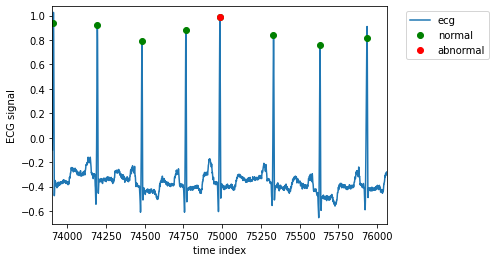

In [281]:
left = ab_index[2]-1080
right = ab_index[2]+1080

plt.plot(x[left:right],p_signal[left:right,0],'-',label='ecg',)
plt.plot(x[atr_sample],p_signal[atr_sample,0],'go',label ='normal')
plt.plot(x[ab_index],p_signal[ab_index,0],'ro',label='abnormal')

plt.xlim(left,right)
plt.ylim(p_signal[left:right].min()-0.05,p_signal[left:right,0].max()+0.05)
plt.xlabel('time index')
plt.ylabel('ECG signal')
plt.legend(bbox_to_anchor = (1.04,1), loc = 'upper left')
plt.show()

# Data Preprocessing

Let's make a dataset that is centered on beats with +- 3 seconds before and after. 

In [18]:
import pywt

In [19]:
def denoise(data):
    coeffs = pywt.wavedec(data=data, wavelet='db5', level=9)
    cA9, cD9, cD8, cD7, cD6, cD5, cD4, cD3, cD2, cD1 = coeffs


    threshold = (np.median(np.abs(cD1)) / 0.6745) * (np.sqrt(2 * np.log(len(cD1))))
    cD1.fill(0)
    cD2.fill(0)
    for i in range(1, len(coeffs) - 2):
        coeffs[i] = pywt.threshold(coeffs[i], threshold)

    rdata = pywt.waverec(coeffs=coeffs, wavelet='db5')
    return rdata

In [232]:
def make_dataset(pts, num_sec, fs, abnormal):
    # function for making dataset ignoring non-beats
    
    # input:
    # pts - list of patients
    # num_sec = number of seconds to include before and after the beat
    # fs = frequency
    
    # output: 
    #   X_all = signal (nbeats , num_sec * fs columns)
    #   Y_all = binary is abnormal (nbeats, 1)
    #   sym_all = beat annotation symbol (nbeats,1)
    
    # initialize numpy arrays
    num_cols = 2*num_sec * fs
    X_all = np.zeros((1,num_cols))
    Y_all = np.zeros((1,1))
    sym_all = []
    
    # list to keep track of number of beats across patients
    max_rows = []
    
    for pt in pts:
        file = data_path + pt
        
        p_signal, atr_sym, atr_sample = load_ecg(file)
        
        # grab the first signal
        p_signal = p_signal[:,0]
        p_signal = denoise(p_signal)
        
        # make df to exclude the nonbeats
        df_ann = pd.DataFrame({'atr_sym':atr_sym,
                              'atr_sample':atr_sample})
        df_ann = df_ann.loc[df_ann.atr_sym.isin(abnormal + ['N'])]
        
        X,Y,sym = build_XY(p_signal,df_ann, num_cols, abnormal)
        sym_all = sym_all+sym
        max_rows.append(X.shape[0])
        X_all = np.append(X_all,X,axis = 0)
        Y_all = np.append(Y_all,Y,axis = 0)
    # drop the first zero row
    X_all = X_all[1:,:]
    Y_all = Y_all[1:,:]
    
    # check sizes make sense
    assert np.sum(max_rows) == X_all.shape[0], 'number of X, max_rows rows messed up'
    assert Y_all.shape[0] == X_all.shape[0], 'number of X, Y rows messed up'
    assert Y_all.shape[0] == len(sym_all), 'number of Y, sym rows messed up'

    return X_all, Y_all, sym_all



def build_XY(p_signal, df_ann, num_cols, abnormal):
    # this function builds the X,Y matrices for each beat
    # it also returns the original symbols for Y
    
    num_rows = len(df_ann)

    X = np.zeros((num_rows, num_cols))
    Y = np.zeros((num_rows,1))
    sym = []
    
    # keep track of rows
    max_row = 0

    for atr_sample, atr_sym in zip(df_ann.atr_sample.values,df_ann.atr_sym.values):

        left = max([0,(atr_sample - num_sec*fs) ])
        right = min([len(p_signal),(atr_sample + num_sec*fs) ])
        x = p_signal[left: right]
        if len(x) == num_cols:
            X[max_row,:] = x
            Y[max_row,:] = int(atr_sym in abnormal)
            sym.append(atr_sym)
            max_row += 1
    X = X[:max_row,:]
    Y = Y[:max_row,:]
    return X,Y,sym

# Lesson 1: split on patients not on samples

Processing all patients

In [233]:
num_sec = 3
fs = 360

In [234]:
X_all, Y_all, sym_all = make_dataset(pts, num_sec, fs, abnormal)

In [390]:
X_all.shape

(109099, 2160)

In [396]:
Y_all.shape

(109099, 1)

In [394]:
len(sym_all)

109099

Text(0, 0.5, 'ECG signal')

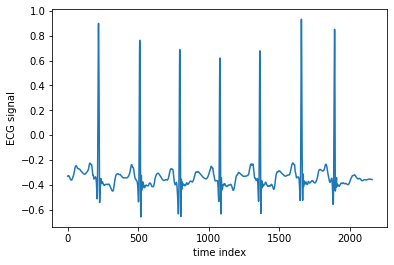

In [450]:
plt.plot(X_all[0],'-',label='ecg',)
plt.xlabel('time index')
plt.ylabel('ECG signal')

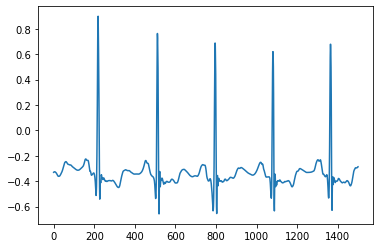

In [370]:
plt.plot(X_all[0, :1500],'-',label='ecg',)

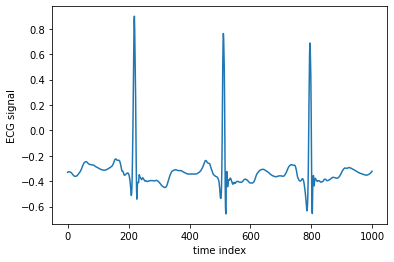

In [452]:
plt.plot(X_all[0, :1000],'-',label='ecg',)
plt.xlabel('time index')
plt.ylabel('ECG signal')
plt.savefig('./with_wavelet.png')

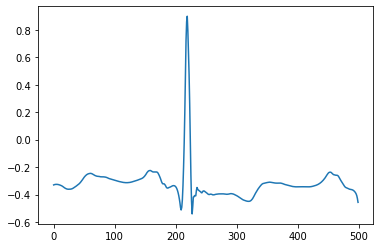

In [371]:
plt.plot(X_all[0, :500],'-',label='ecg',)

In [300]:
X_all.T.shape

(2160, 109099)

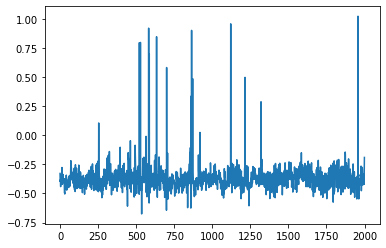

In [368]:
plt.plot(X_all.T[1, :2000],'-',label='ecg',)

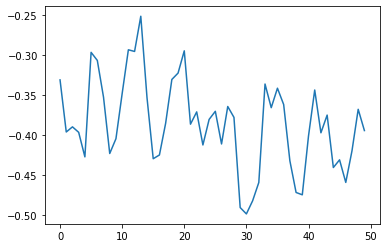

In [305]:
plt.plot(X_all.T[10, :50],'-',label='ecg',)

In [23]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X_all, Y_all, test_size=0.25, random_state=42)

In [24]:
import tensorflow as tf
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
print("Tensorflow version:", tf.__version__)
print(tf.test.is_gpu_available())

Tensorflow version: 2.3.1
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True


In [25]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [26]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score
def calc_prevalence(y_actual):
    return (sum(y_actual)/len(y_actual))
def calc_specificity(y_actual, y_pred, thresh):
    # calculates specificity
    return sum((y_pred < thresh) & (y_actual == 0)) /sum(y_actual ==0)
def print_report(y_actual, y_pred, thresh):
    
    auc = roc_auc_score(y_actual, y_pred)
    accuracy = accuracy_score(y_actual, (y_pred > thresh))
    recall = recall_score(y_actual, (y_pred > thresh))
    precision = precision_score(y_actual, (y_pred > thresh))
    specificity = calc_specificity(y_actual, y_pred, thresh)
    print('AUC:%.3f'%auc)
    print('accuracy:%.3f'%accuracy)
    print('recall:%.3f'%recall)
    print('precision:%.3f'%precision)
    print('specificity:%.3f'%specificity)
    print('prevalence:%.3f'%calc_prevalence(y_actual))
    print(' ')
    return auc, accuracy, recall, precision, specificity

### Dense Neural Net

In [27]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.utils import to_categorical

By splitting on patients instead of samples

In [326]:
import random
random.seed( 42 )
pts_train = random.sample(pts, 36)
pts_valid = [pt for pt in pts if pt not in pts_train]
print(len(pts_train), len(pts_valid))

36 12


In [327]:
X_train, y_train, sym_train = make_dataset(pts_train, num_sec, fs, abnormal)
X_valid, y_valid, sym_valid = make_dataset(pts_valid, num_sec, fs, abnormal)
print(X_train.shape, y_train.shape, len(sym_train))
print(X_valid.shape, y_valid.shape, len(sym_valid))

(80614, 2160) (80614, 1) 80614
(28485, 2160) (28485, 1) 28485


---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [30]:
# build the same model
# lets test out relu (a different activation function) and add drop out (for regularization)
model = Sequential()
model.add(Dense(64, activation = 'relu', input_dim = X_train.shape[1]))
model.add(Dropout(rate = 0.5))
model.add(Dense(32, activation = 'relu'))
model.add(Dropout(rate = 0.5))
model.add(Dense(1, activation = 'sigmoid'))

# compile the model - use categorical crossentropy, and the adam optimizer
model.compile(
                loss = 'binary_crossentropy',
                optimizer = 'adam',
                metrics = ['accuracy'])

model.fit(X_train, y_train, batch_size = 32, epochs= 5, verbose = 1)

Epoch 1/5
2520/2520 [==============================] - 10s 4ms/step - loss: 0.3442 - accuracy: 0.8654
Epoch 2/5
2520/2520 [==============================] - 10s 4ms/step - loss: 0.2026 - accuracy: 0.9340
Epoch 3/5
2520/2520 [==============================] - 10s 4ms/step - loss: 0.1734 - accuracy: 0.9457
Epoch 4/5
2520/2520 [==============================] - 9s 4ms/step - loss: 0.1592 - accuracy: 0.9503
Epoch 5/5
2520/2520 [==============================] - 9s 4ms/step - loss: 0.1462 - accuracy: 0.9553


In [31]:
y_train_preds_dense = model.predict(X_train,verbose = 1)
y_valid_preds_dense = model.predict(X_valid,verbose = 1)

891/891 [==============================] - 1s 1ms/step


In [32]:
thresh = (sum(y_train)/len(y_train))[0]
thresh

0.29906715955045027

In [442]:
print('Train');
print_report(y_train, y_train_preds_dense, thresh)
print('Valid');
print_report(y_valid, y_valid_preds_dense, thresh);

Train
AUC:0.992
accuracy:0.974
recall:0.946
precision:0.965
specificity:0.986
prevalence:0.299
 
Valid
AUC:0.845
accuracy:0.745
recall:0.374
precision:0.815
specificity:0.953
prevalence:0.358
 


# Lesson 2: learning curve can tells us we should get more data! 

In [34]:
aucs_train = []
aucs_valid = []

n_pts = [1,18,36]
for n_pt in n_pts:
    
    print(n_pt)
    pts_sub = pts_train[:n_pt]
    X_sub, y_sub, sym_sub = make_dataset(pts_sub, num_sec, fs,abnormal)

    # build the same model
    # lets test out relu (a different activation function) and add drop out (for regularization)
    model = Sequential()
    model.add(Dense(32, activation = 'relu', input_dim = X_train.shape[1]))
    model.add(Dropout(rate = 0.25))
    model.add(Dense(1, activation = 'sigmoid'))

    # compile the model - use categorical crossentropy, and the adam optimizer
    model.compile(
                    loss = 'binary_crossentropy',
                    optimizer = 'adam',
                    metrics = ['accuracy'])

    model.fit(X_sub, y_sub, batch_size = 32, epochs= 5, verbose = 0)
    y_sub_preds_dense = model.predict(X_sub,verbose = 0)
    y_valid_preds_dense = model.predict(X_valid,verbose = 0)
    
    auc_train = roc_auc_score(y_sub, y_sub_preds_dense)
    auc_valid = roc_auc_score(y_valid, y_valid_preds_dense)
    print('-',auc_train, auc_valid)
    aucs_train.append(auc_train)
    aucs_valid.append(auc_valid)

1
- 0.9271421348516103 0.6822824066836652
18
- 0.9952978759813371 0.7979209810016863
36
- 0.9915161085811168 0.8449611364612044


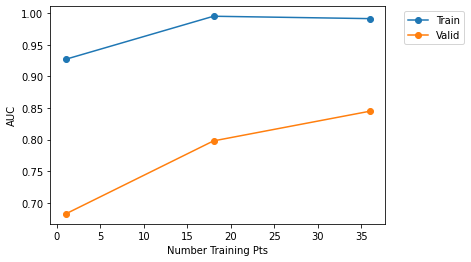

In [35]:
plt.plot(n_pts, aucs_train, 'o-',label = 'Train')
plt.plot(n_pts, aucs_valid, 'o-',label = 'Valid')
plt.xlabel('Number Training Pts')
plt.ylabel('AUC')
plt.legend(bbox_to_anchor = (1.04,1), loc = 'upper left')
plt.show()

More data appears to add extra value to the model. 

# Lesson 3: test multiple types of deep learning models

## CNN

### Simple CNN

In [328]:
# reshape input to be [samples, time steps, features = 1]
X_train_cnn = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_valid_cnn = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1], 1))

print(X_train_cnn.shape)
print(X_valid_cnn.shape)

(80614, 2160, 1)
(28485, 2160, 1)


In [329]:
from keras.layers import Conv1D, MaxPool1D, AvgPool1D

In [38]:
model = Sequential()
model.add(Conv1D(filters = 128, kernel_size = 5, activation = 'relu', input_shape = (2160,1)))
model.add(Dropout(rate = 0.5))
model.add(Flatten())
model.add(Dense(1, activation = 'sigmoid'))

# compile the model - use categorical crossentropy, and the adam optimizer
model.compile(loss = 'binary_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

In [39]:
model.fit(X_train_cnn, y_train, batch_size = 32, epochs= 5, verbose = 1)

Epoch 1/5
2520/2520 [==============================] - 13s 5ms/step - loss: 0.2099 - accuracy: 0.9283
Epoch 2/5
2520/2520 [==============================] - 13s 5ms/step - loss: 0.1329 - accuracy: 0.9608
Epoch 3/5
2520/2520 [==============================] - 13s 5ms/step - loss: 0.1068 - accuracy: 0.9681
Epoch 4/5
2520/2520 [==============================] - 13s 5ms/step - loss: 0.0997 - accuracy: 0.9703
Epoch 5/5
2520/2520 [==============================] - 13s 5ms/step - loss: 0.0906 - accuracy: 0.9724


In [40]:
y_train_preds_cnn = model.predict(X_train_cnn,verbose = 1)
y_valid_preds_cnn = model.predict(X_valid_cnn,verbose = 1)

891/891 [==============================] - 1s 1ms/step


In [41]:
print('Train');
print_report(y_train, y_train_preds_cnn, thresh)
print('Valid');
print_report(y_valid, y_valid_preds_cnn, thresh);

Train
AUC:0.994
accuracy:0.978
recall:0.963
precision:0.963
specificity:0.984
prevalence:0.299
 
Valid
AUC:0.921
accuracy:0.853
recall:0.805
precision:0.789
specificity:0.880
prevalence:0.358
 


### Improved CNN

In [470]:
model = Sequential()
model.add(Conv1D(filters = 4, kernel_size = 21, strides=1, padding='SAME', activation = 'relu', input_shape = (X_train_cnn.shape[1], X_train_cnn.shape[2])))
model.add(MaxPool1D(pool_size=3, strides=2, padding='SAME'))
model.add(Conv1D(filters = 8, kernel_size = 23, strides=1, padding='SAME', activation = 'relu'))
model.add(MaxPool1D(pool_size=3, strides=2, padding='SAME'))
model.add(Conv1D(filters = 16, kernel_size = 25, strides=1, padding='SAME', activation = 'relu'))
model.add(MaxPool1D(pool_size=3, strides=2, padding='SAME'))
model.add(Conv1D(filters = 32, kernel_size = 25, strides=1, padding='SAME', activation = 'relu'))
model.add(AvgPool1D(pool_size=3, strides=2, padding='SAME'))
model.add(Conv1D(filters = 32, kernel_size = 27, strides=1, padding='SAME', activation = 'relu'))
model.add(Flatten())
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(rate = 0.25))
model.add(Dense(1, activation = 'sigmoid'))

# compile the model - use categorical crossentropy, and the adam optimizer
model.compile(loss = 'binary_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

In [471]:
model.fit(X_train_cnn, y_train, batch_size = 32, epochs= 5, verbose = 1)

Epoch 1/5
2520/2520 [==============================] - 20s 8ms/step - loss: 0.0681 - accuracy: 0.9768
Epoch 2/5
2520/2520 [==============================] - 20s 8ms/step - loss: 0.0255 - accuracy: 0.9917
Epoch 3/5
2520/2520 [==============================] - 20s 8ms/step - loss: 0.0182 - accuracy: 0.9944
Epoch 4/5
2520/2520 [==============================] - 20s 8ms/step - loss: 0.0147 - accuracy: 0.9953
Epoch 5/5
2520/2520 [==============================] - 20s 8ms/step - loss: 0.0121 - accuracy: 0.9966


In [475]:
model.summary()

Model: "sequential_60"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_49 (Conv1D)           (None, 2160, 4)           88        
_________________________________________________________________
max_pooling1d_26 (MaxPooling (None, 1080, 4)           0         
_________________________________________________________________
conv1d_50 (Conv1D)           (None, 1080, 8)           744       
_________________________________________________________________
max_pooling1d_27 (MaxPooling (None, 540, 8)            0         
_________________________________________________________________
conv1d_51 (Conv1D)           (None, 540, 16)           3216      
_________________________________________________________________
max_pooling1d_28 (MaxPooling (None, 270, 16)           0         
_________________________________________________________________
conv1d_52 (Conv1D)           (None, 270, 32)         

In [472]:
y_train_preds_wavecnn = model.predict(X_train_cnn,verbose = 1)
y_valid_preds_wavecnn = model.predict(X_valid_cnn,verbose = 1)

891/891 [==============================] - 3s 3ms/step


In [473]:
print('Train');
print_report(y_train, y_train_preds_wavecnn, thresh)
print('Valid');
print_report(y_valid, y_valid_preds_wavecnn, thresh);

Train
AUC:1.000
accuracy:0.996
recall:0.999
precision:0.987
specificity:0.994
prevalence:0.299
 
Valid
AUC:0.978
accuracy:0.905
recall:0.951
precision:0.815
specificity:0.880
prevalence:0.358
 


## LSTM

In [330]:
from keras.layers import Bidirectional, LSTM, Attention

In [413]:
model = Sequential()
model.add(Bidirectional(LSTM(32, input_shape=(X_train_cnn.shape[1], X_train_cnn.shape[2]))))
model.add(Dense(32, activation = 'sigmoid'))
model.add(Dropout(rate = 0.5))
model.add(Dense(32, activation = 'sigmoid'))
model.add(Dropout(rate = 0.2))
model.add(Dense(64, activation = 'sigmoid'))
model.add(Dropout(rate = 0.5))
model.add(Dense(64, activation = 'sigmoid'))
model.add(Dropout(rate = 0.1))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss = 'binary_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

In [414]:
checkpoint_path = "./save/lstm_denoise"
checkpoint_dir = os.path.dirname(checkpoint_path)

# 모델의 가중치를 저장하는 콜백 만들기
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [415]:
model.fit(X_train_cnn[:10000], y_train[:10000], batch_size = 64, epochs = 5, verbose = 1, callbacks=[cp_callback])

Epoch 1/5
157/157 [==============================] - ETA: 0s - loss: 0.7013 - accuracy: 0.5036
Epoch 00001: saving model to ./save/lstm_denoise
157/157 [==============================] - 27s 175ms/step - loss: 0.7013 - accuracy: 0.5036
Epoch 2/5
157/157 [==============================] - ETA: 0s - loss: 0.5765 - accuracy: 0.7162
Epoch 00002: saving model to ./save/lstm_denoise
157/157 [==============================] - 27s 172ms/step - loss: 0.5765 - accuracy: 0.7162
Epoch 3/5
157/157 [==============================] - ETA: 0s - loss: 0.5173 - accuracy: 0.7800
Epoch 00003: saving model to ./save/lstm_denoise
157/157 [==============================] - 27s 171ms/step - loss: 0.5173 - accuracy: 0.7800
Epoch 4/5
157/157 [==============================] - ETA: 0s - loss: 0.5350 - accuracy: 0.7447
Epoch 00004: saving model to ./save/lstm_denoise
157/157 [==============================] - 27s 171ms/step - loss: 0.5350 - accuracy: 0.7447
Epoch 5/5
157/157 [==============================] - ETA

In [416]:
y_train_preds_lstm = model.predict(X_train_cnn[:10000],verbose = 1)
y_valid_preds_lstm = model.predict(X_valid_cnn,verbose = 1)

891/891 [==============================] - 71s 80ms/step


In [417]:
print('Train');
print_report(y_train[:10000], y_train_preds_lstm, thresh)
print('Valid');
print_report(y_valid, y_valid_preds_lstm, thresh);

Train
AUC:0.884
accuracy:0.797
recall:0.919
precision:0.733
specificity:0.679
prevalence:0.489
 
Valid
AUC:0.556
accuracy:0.553
recall:0.456
precision:0.393
specificity:0.606
prevalence:0.358
 


# New

## LSTM + Attention

In [336]:
from keras.layers import Bidirectional, LSTM, Attention
TIME_STEPS = X_train_cnn.shape[1]
INPUT_DIM  = X_train_cnn.shape[2]

In [337]:
def attention_3d_block(inputs):
    
    # inputs.shape = (batch_size, time_steps, input_dim)
    input_dim = int(X_train_cnn.shape[2])
    
    a = tf.keras.layers.Permute((2, 1))(inputs) # same transpose
    #a = tf.keras.layers.Reshape((input_dim, TIME_STEPS))(a) 
    # this line is not useful. It's just to know which dimension is what.
    a = tf.keras.layers.Dense(TIME_STEPS, activation='softmax')(a)
    
    a_probs = tf.keras.layers.Permute((2, 1), name='attention_vec')(a)
    
    output_attention_mul  = tf.keras.layers.multiply([inputs, a_probs])
    #output_attention_mul = merge([inputs, a_probs], name='attention_mul', mode='mul')
    return output_attention_mul

In [338]:
def model_attention_applied_after_lstm():
    
    inputs        = tf.keras.Input(shape=(TIME_STEPS, INPUT_DIM,))
    lstm_units    = 64
    
    lstm_out      = tf.keras.layers.LSTM(lstm_units, return_sequences=True)(inputs)
    
    attention_mul = attention_3d_block(lstm_out)
    attention_mul = tf.keras.layers.Flatten()(attention_mul)
    
    output        = tf.keras.layers.Dense(1, activation='sigmoid')(attention_mul)
    
    model         = tf.keras.Model(inputs=[inputs], outputs=output)
    
    return model

In [354]:
def model_attentions_applied_after_lstm():
    
    inputs        = tf.keras.Input(shape=(TIME_STEPS, INPUT_DIM,))
    lstm_units    = 64
    
    lstm_out1      = tf.keras.layers.LSTM(lstm_units, return_sequences=True)(inputs)
    lstm_out2      = tf.keras.layers.LSTM(16, return_sequences=True)(lstm_out1)
    lstm_out3      = tf.keras.layers.LSTM(32, return_sequences=True)(lstm_out2)
    
    attention_mul = attention_3d_block(lstm_out3)
    attention_mul = tf.keras.layers.Flatten()(attention_mul)
    
    output        = tf.keras.layers.Dense(1, activation='sigmoid')(attention_mul)
    
    model         = tf.keras.Model(inputs=[inputs], outputs=output)
    
    return model

In [340]:
def get_data_recurrent(n, time_steps, input_dim, attention_column=10):

    x = np.random.standard_normal(size=(n, time_steps, input_dim))
    y = np.random.randint(low=0, high=2, size=(n, 1))

    x[:, attention_column, :] = np.tile(y, input_dim)

    return x, y

In [355]:
train_x_att, train_y_att = get_data_recurrent(30000, TIME_STEPS, INPUT_DIM)

modelatt = model_attention_applied_after_lstm()
modelatts = model_attentions_applied_after_lstm()
modelatt.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
modelatts.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [342]:
modelatt.fit([train_x_att], train_y_att, epochs=3, batch_size=32, validation_split=0.1)

Epoch 1/3
844/844 [==============================] - 79s 94ms/step - loss: 0.2189 - accuracy: 0.9064 - val_loss: 0.0076 - val_accuracy: 1.0000
Epoch 2/3
844/844 [==============================] - 79s 93ms/step - loss: 0.0034 - accuracy: 1.0000 - val_loss: 0.0015 - val_accuracy: 1.0000
Epoch 3/3
844/844 [==============================] - 79s 93ms/step - loss: 9.4677e-04 - accuracy: 1.0000 - val_loss: 5.7339e-04 - val_accuracy: 1.0000


In [356]:
modelatts.fit([train_x_att], train_y_att, epochs=5, batch_size=32, validation_split=0.1)

layer_outputs    = [layer.output for layer in modelatts.layers if layer.name == 'attention_vec']
activation_model = tf.keras.models.Model(inputs=modelatts.input, outputs=layer_outputs)

Epoch 1/5
844/844 [==============================] - 218s 259ms/step - loss: 0.6820 - accuracy: 0.5563 - val_loss: 0.6519 - val_accuracy: 0.6297
Epoch 2/5
844/844 [==============================] - 216s 256ms/step - loss: 0.6424 - accuracy: 0.6012 - val_loss: 0.6683 - val_accuracy: 0.6083
Epoch 3/5
844/844 [==============================] - 218s 258ms/step - loss: 0.5444 - accuracy: 0.7065 - val_loss: 0.3259 - val_accuracy: 0.8570
Epoch 4/5
844/844 [==============================] - 218s 258ms/step - loss: 0.4178 - accuracy: 0.7847 - val_loss: 0.6815 - val_accuracy: 0.6377
Epoch 5/5
844/844 [==============================] - 216s 256ms/step - loss: 0.2944 - accuracy: 0.8662 - val_loss: 0.0438 - val_accuracy: 0.9873


In [344]:
y_train_preds_lstm_att = modelatt.predict(X_train_cnn[:10000],verbose = 1)
y_valid_preds_lstm_att = modelatt.predict(X_valid_cnn,verbose = 1)

891/891 [==============================] - 38s 42ms/step


In [357]:
y_train_preds_lstm_atts = modelatts.predict(X_train_cnn[:10000],verbose = 1)
y_valid_preds_lstm_atts = modelatts.predict(X_valid_cnn,verbose = 1)

891/891 [==============================] - 111s 124ms/step


In [358]:
print('Train');
print_report(y_train[:10000], y_train_preds_lstm_att, thresh)
print('Valid');
print_report(y_valid, y_valid_preds_lstm_att, thresh);

Train
AUC:0.625
accuracy:0.544
recall:0.130
precision:0.676
specificity:0.940
prevalence:0.489
 
Valid
AUC:0.540
accuracy:0.636
recall:0.046
precision:0.421
specificity:0.964
prevalence:0.358
 


In [359]:
print('Train');
print_report(y_train[:10000], y_train_preds_lstm_atts, thresh)
print('Valid');
print_report(y_valid, y_valid_preds_lstm_atts, thresh);

Train
AUC:0.582
accuracy:0.533
recall:0.109
precision:0.634
specificity:0.940
prevalence:0.489
 
Valid
AUC:0.481
accuracy:0.636
recall:0.050
precision:0.429
specificity:0.963
prevalence:0.358
 


## Deep LSTM

In [64]:
from keras.layers import Bidirectional, LSTM, Embedding, Attention

In [90]:
model = Sequential()
model.add(Bidirectional(LSTM(64, return_sequences = True, input_shape=(X_train_cnn.shape[1], X_train_cnn.shape[2]))))
model.add(Bidirectional(LSTM(32, return_sequences = True)))
model.add(Bidirectional(LSTM(32, return_sequences = False)))
model.add(Dropout(rate = 0.2))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss = 'binary_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

In [91]:
model.fit(X_train_cnn[:10000], y_train[:10000], batch_size = 32, epochs = 3, verbose = 1)

Epoch 1/3
313/313 [==============================] - 150s 479ms/step - loss: 0.4191 - accuracy: 0.8123
Epoch 2/3
313/313 [==============================] - 150s 478ms/step - loss: 0.2759 - accuracy: 0.8980
Epoch 3/3
313/313 [==============================] - 149s 476ms/step - loss: 0.2612 - accuracy: 0.9047


In [92]:
y_train_preds_dblstm = model.predict(X_train_cnn[:10000],verbose = 1)
y_valid_preds_dblstm = model.predict(X_valid_cnn,verbose = 1)

891/891 [==============================] - 216s 243ms/step


In [93]:
print('Train');
print_report(y_train[:10000], y_train_preds_dblstm, thresh)
print('Valid');
print_report(y_valid, y_valid_preds_dblstm, thresh);

Train
AUC:0.958
accuracy:0.912
recall:0.901
precision:0.918
specificity:0.922
prevalence:0.489
 
Valid
AUC:0.590
accuracy:0.591
recall:0.488
precision:0.437
specificity:0.649
prevalence:0.358
 


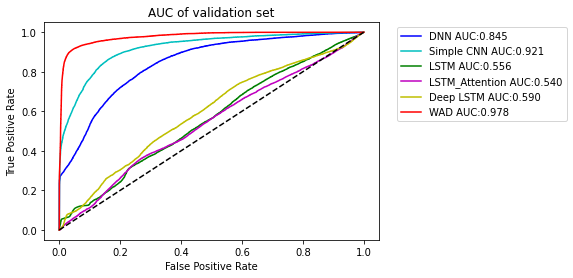

In [474]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr_valid_dense, tpr_valid_dense, t_valid_dense = roc_curve(y_valid, y_valid_preds_dense)
auc_valid_dense = roc_auc_score(y_valid, y_valid_preds_dense)

fpr_valid_cnn, tpr_valid_cnn, t_valid_cnn = roc_curve(y_valid, y_valid_preds_cnn)
auc_valid_cnn = roc_auc_score(y_valid, y_valid_preds_cnn)

fpr_valid_wavecnn, tpr_valid_wavecnn, t_valid_wavecnn = roc_curve(y_valid, y_valid_preds_wavecnn)
auc_valid_wavecnn = roc_auc_score(y_valid, y_valid_preds_wavecnn)

fpr_valid_lstm, tpr_valid_lstm, t_valid_lstm = roc_curve(y_valid, y_valid_preds_lstm)
auc_valid_lstm = roc_auc_score(y_valid, y_valid_preds_lstm)

fpr_valid_lstm_att, tpr_valid_lstm_att, t_valid_lstm_att = roc_curve(y_valid, y_valid_preds_lstm_att)
auc_valid_lstm_att = roc_auc_score(y_valid, y_valid_preds_lstm_att)

fpr_valid_dblstm, tpr_valid_dblstm, t_valid_dblstm = roc_curve(y_valid, y_valid_preds_dblstm)
auc_valid_dblstm = roc_auc_score(y_valid, y_valid_preds_dblstm)

plt.plot(fpr_valid_dense, tpr_valid_dense, 'b', label = 'DNN AUC:%.3f'%auc_valid_dense)
plt.plot(fpr_valid_cnn, tpr_valid_cnn, 'c', label = 'Simple CNN AUC:%.3f'%auc_valid_cnn)
plt.plot(fpr_valid_lstm, tpr_valid_lstm, 'g', label = 'LSTM AUC:%.3f'%auc_valid_lstm)
plt.plot(fpr_valid_lstm_att, tpr_valid_lstm_att, 'm', label = 'LSTM_Attention AUC:%.3f'%auc_valid_lstm_att)
plt.plot(fpr_valid_dblstm, tpr_valid_dblstm, 'y', label = 'Deep LSTM AUC:%.3f'%auc_valid_dblstm)
plt.plot(fpr_valid_wavecnn, tpr_valid_wavecnn, 'r', label = 'WAD AUC:%.3f'%auc_valid_wavecnn)

plt.plot([0,1],[0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(bbox_to_anchor = (1.04,1), loc = 'best')
plt.title('AUC of validation set')

plt.savefig('./savefig_denoise.png')
plt.show()

In [443]:
tf.__version__

'2.3.1'

In [447]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 12565683815232942805,
 name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 15531266345961171040
 physical_device_desc: "device: XLA_CPU device",
 name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 7267098840928407001
 physical_device_desc: "device: XLA_GPU device",
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 8695073984
 locality {
   bus_id: 2
   numa_node: 1
   links {
   }
 }
 incarnation: 15734608074686091231
 physical_device_desc: "device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:b1:00.0, compute capability: 7.5"]